In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (mean_squared_error, mean_absolute_error, f1_score, recall_score,
                             precision_score, confusion_matrix, plot_confusion_matrix)


import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier

from utils import split_reservations
from features import X1_cxl_cols, X2_cxl_cols

In [2]:
pd.options.display.max_rows = 60
pd.options.display.max_columns = 70

In [3]:
h1_res = pd.read_pickle("pickle/h1_res.pick")
h2_res = pd.read_pickle("pickle/h2_res.pick")
h1_dbd = pd.read_pickle("pickle/h1_dbd.pick")
h2_dbd = pd.read_pickle("pickle/h2_dbd.pick")

In [4]:
X1_train, X1_test, y1_train, y1_test = split_reservations(h1_res, as_of_date="2017-08-01", features=X1_cxl_cols)

Training sample size: 38295 
 Testing Sample Size: 1765


In [5]:
y1_test

12815    1
12816    1
12859    1
12874    1
12911    1
        ..
40055    0
40056    0
40057    0
40058    0
40059    0
Name: IsCanceled, Length: 1765, dtype: int64

In [6]:
X2_train, X2_test, y2_train, y2_test = split_reservations(h2_res, as_of_date="2017-08-01", features=X2_cxl_cols)

Training sample size: 76320 
 Testing Sample Size: 3010


In [7]:
y1_train

0        0
1        0
2        0
3        0
4        0
        ..
40014    0
40020    0
40022    0
40032    0
40035    0
Name: IsCanceled, Length: 38295, dtype: int64

## H1 Final XGBoost Model

In [8]:
xgb_1 = XGBClassifier(objective='binary:logistic',
                      use_label_encoder=False,
                      eval_metric='logloss',
                      random_state=41,
                      n_jobs=-1,
                      learning_rate=0.11,
                      max_depth=5,
                      n_estimators=475
                          
)

xgb_model_1 = xgb_1.fit(X1_train, y1_train)

In [ ]:
h1_best_thresh, h1_best_fbeta = optimize_prob_threshold(xgb_model_1)

### First grid search results

**H1 grid search setup**
```
estimator = XGBClassifier(objective='binary:logistic',
                          use_label_encoder=False,
                          eval_metric='logloss',
                          random_state=42,
)

params = {
    'learning_rate': [0.0001,0.01],
    'max_depth': range(2,8,2),
    'n_estimators': [200, 300, 400]
}

grid_search_1 = GridSearchCV(
    estimator = estimator,
    param_grid = params,
    n_jobs=-1,
    verbose=100
)

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2,random_state=42)

```

**And the results**:
```
Fitting 5 folds for each of 18 candidates, totalling 90 fits
The best parameters are: 
 {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 400}
CPU times: user 53.5 s, sys: 414 ms, total: 53.9 s
Wall time: 1h 27min 17s
```

R^2 score: 0.830629056415377

**H2 grid search setup was the same as H1 grid search setup (round 1)**

**And the results**:

```
Fitting 5 folds for each of 18 candidates, totalling 90 fits
The best parameters are: 
 {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 400}
CPU times: user 1min 37s, sys: 262 ms, total: 1min 38s
Wall time: 1h 32min 4s
```

R^2 score: 0.8276818353712341

### Second Round

H1 setup & results
```
estimator = XGBClassifier(objective='binary:logistic',
                          use_label_encoder=False,
                          eval_metric='logloss',
                          random_state=42,
)

params = {
    'learning_rate': [0.005, 0.01, 0.05, 0.1],
    'max_depth': range(5,6,7),
    'n_estimators': [350, 400, 450]
}

grid_search_1 = GridSearchCV(
    estimator = estimator,
    param_grid = params,
    n_jobs=-1,
    verbose=100
)

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2,random_state=42)

# ---------RESULTS----------
Fitting 5 folds for each of 12 candidates, totalling 60 fits
The best parameters are: 
 {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 400}
CPU times: user 40.9 s, sys: 325 ms, total: 41.2 s
Wall time: 1h 37min 13s
```

R^2 score: 0.8514727908137794

H2 results (setup the same as H1 round 2):

```

# SETUP SAME AS H1 ROUND 2

# ---------RESULTS----------
Fitting 5 folds for each of 12 candidates, totalling 60 fits
The best parameters are: 
 {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 450}
CPU times: user 1min 29s, sys: 236 ms, total: 1min 29s
Wall time: 1h 41min 45s
```
R^2 score: 0.84904827933946

### Round 3

H1 setup different than H2 setup this time.

H1 setup:
```
estimator = XGBClassifier(objective='binary:logistic',
                          use_label_encoder=False,
                          eval_metric='logloss',
                          random_state=42,
                          max_depth=5
)

params = {
    'learning_rate': [0.08, 0.09, 0.1, 0.11, 0.12],
    'n_estimators': [380, 390, 400, 410, 420, 475]
}

grid_search_1 = GridSearchCV(
    estimator = estimator,
    param_grid = params,
    n_jobs=-1,
    verbose=100
)

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2,random_state=42)

# ---------RESULTS----------
Fitting 5 folds for each of 30 candidates, totalling 150 fits
The best parameters are: 
 {'learning_rate': 0.11, 'n_estimators': 475}
CPU times: user 49.1 s, sys: 437 ms, total: 49.5 s
Wall time: 4h 8min 47s
```
R^2 score: 0.854218671992012

And H2 setup:

```
estimator = XGBClassifier(objective='binary:logistic',
                          use_label_encoder=False,
                          eval_metric='logloss',
                          random_state=42,
)

# further tuning params
params = {
    'learning_rate': [0.08, 0.09, 0.1, 0.11, 0.12],
    'n_estimators': [440, 450, 475, 500, 550]
}


grid_search_2 = GridSearchCV(
    estimator = estimator,
    param_grid = params,
    n_jobs=-1,
    verbose=100
)

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2,random_state=42)

# ---------RESULTS----------
Fitting 5 folds for each of 25 candidates, totalling 125 fits
The best parameters are: 
 {'learning_rate': 0.12, 'n_estimators': 550}
CPU times: user 2min 8s, sys: 187 ms, total: 2min 8s
Wall time: 5h 5min 44s
```

R^2 score: 0.8564225387621328

In [9]:
from utils import optimize_prob_threshold

Optimal probability threshold (to maximize F-0.5): 0.6000000000000002 
 F-0.5 Score: 0.745


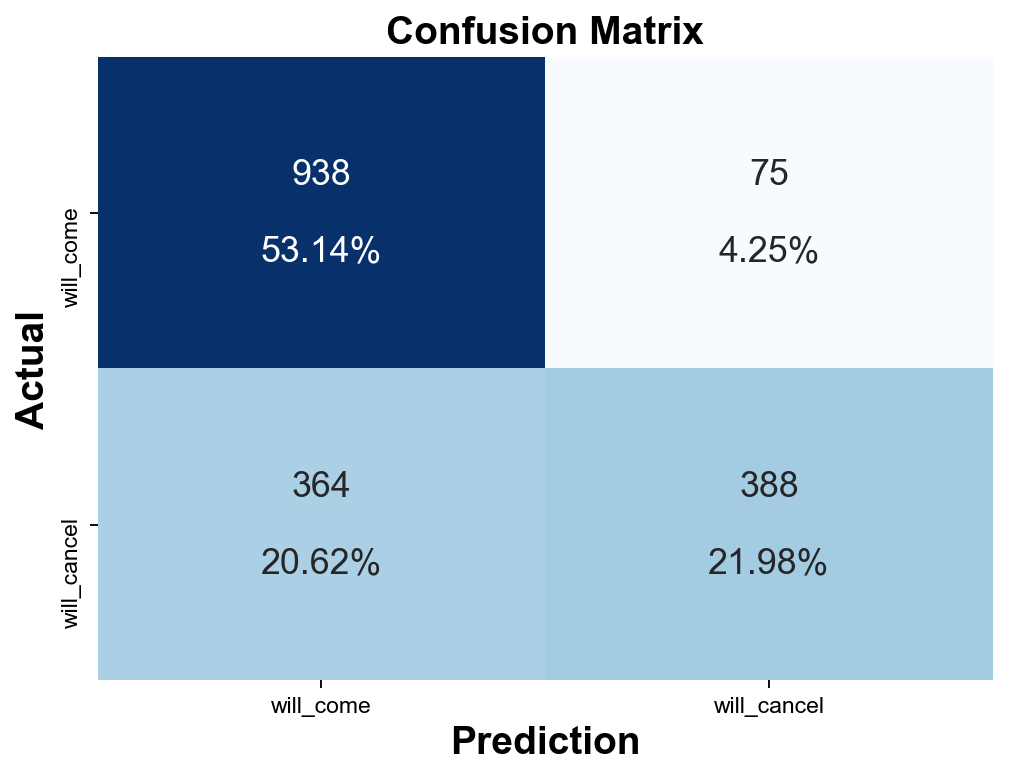

In [10]:
h1_best_thresh, h1_best_fbeta = optimize_prob_threshold(xgb_model_1, X_test=X1_test, y_test=y1_test)